In [8]:
import torch
import numpy as np
import torch.nn as nn
from scipy.io import loadmat
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from Dataset import Dataset, device
torch.set_default_dtype(torch.float64)

In [9]:
train = loadmat('data_training_reactor_pol.mat')
test = loadmat('data_validation_reactor_pol.mat')

y_train = 0.0001*(train['NAMW'][0]-train['NAMW'][0][0])
y_test = 0.0001*(test['NAMW'][0]-test['NAMW'][0][0])

x_train = np.concatenate((100*np.concatenate(([[0]], (train['FI'].T[1:]-train['FI'].T[0])), axis=0),
                          100*np.concatenate(([[0], [0]], (train['FI'].T[2:]-train['FI'].T[0])), axis=0),
                          np.concatenate(([0], y_train[1:]), axis=0).reshape(-1, 1),
                          np.concatenate(([0, 0], y_train[2:]), axis=0).reshape(-1, 1)), axis=1)

x_test = np.concatenate((100*np.concatenate(([[0]], (test['FI'].T[1:]-test['FI'].T[0])), axis=0),
                         100*np.concatenate(([[0], [0]], (test['FI'].T[2:]-test['FI'].T[0])), axis=0),
                         np.concatenate(([0], y_test[1:]), axis=0).reshape(-1, 1),
                         np.concatenate(([0, 0], y_test[2:]), axis=0).reshape(-1, 1)), axis=1)

In [10]:
trainset = Dataset(x_train, y_train)
testset = Dataset(x_test, y_test)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

In [11]:
class Perceptron(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.activation = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

model = Perceptron(4, 100, 1).to(device)

In [12]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Epoch: [1/100], loss: 0.3255
Epoch: [2/100], loss: 0.2152
Epoch: [3/100], loss: 0.1421
Epoch: [4/100], loss: 0.2365
Epoch: [5/100], loss: 0.2101
Epoch: [6/100], loss: 0.1291
Epoch: [7/100], loss: 0.2186
Epoch: [8/100], loss: 0.1562
Epoch: [9/100], loss: 0.2266
Epoch: [10/100], loss: 0.1313
Epoch: [11/100], loss: 0.1831
Epoch: [12/100], loss: 0.1882
Epoch: [13/100], loss: 0.1660
Epoch: [14/100], loss: 0.1023
Epoch: [15/100], loss: 0.1854
Epoch: [16/100], loss: 0.1539
Epoch: [17/100], loss: 0.1184
Epoch: [18/100], loss: 0.1096
Epoch: [19/100], loss: 0.1659
Epoch: [20/100], loss: 0.1677
Epoch: [21/100], loss: 0.1234
Epoch: [22/100], loss: 0.1539
Epoch: [23/100], loss: 0.0896
Epoch: [24/100], loss: 0.0448
Epoch: [25/100], loss: 0.0878
Epoch: [26/100], loss: 0.0890
Epoch: [27/100], loss: 0.1043
Epoch: [28/100], loss: 0.0683
Epoch: [29/100], loss: 0.0911
Epoch: [30/100], loss: 0.0682
Epoch: [31/100], loss: 0.0994
Epoch: [32/100], loss: 0.0925
Epoch: [33/100], loss: 0.0645
Epoch: [34/100], lo

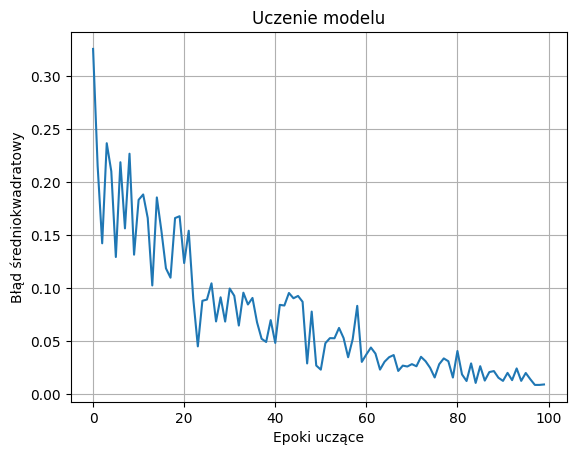

In [13]:
num_epochs = 100
all_losses = []
model.train()

for epoch in range(num_epochs):
    for i, (x, y) in enumerate(trainloader):
        optimizer.zero_grad()
        x, y = x.reshape(-1, 4).to(device), y.reshape(-1, 1).to(device)
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
    all_losses.append(loss.item())
    print(f'Epoch: [{epoch+1}/{num_epochs}], loss: {loss.item():.4f}')

plt.plot(all_losses)
# plt.yscale('log')
plt.title('Uczenie modelu')
plt.xlabel('Epoki uczące')
plt.ylabel('Błąd średniokwadratowy')
plt.grid()
plt.show()

Train error: 0.012414488399133476
Test error: 0.013544851407138988


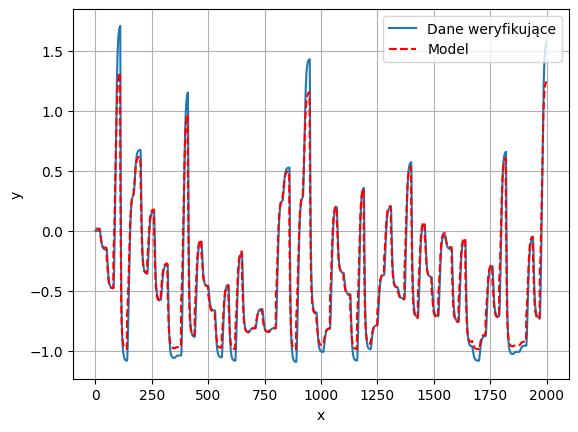

In [14]:
print(f'Train error: {(model(trainset[:][0].clone().detach().reshape(-1, 4).to(device))-trainset[:][1].reshape(-1, 1).to(device)).reshape(-1).pow(2).mean()}')
print(f'Test error: {(model(testset[:][0].clone().detach().reshape(-1, 4).to(device))-testset[:][1].reshape(-1, 1).to(device)).reshape(-1).pow(2).mean()}')
plt.plot(y_test)
plt.plot(model(torch.tensor(x_test).reshape(-1, 4).to(device)).cpu().detach().numpy(), 'r--')
plt.legend(['Dane weryfikujące', 'Model'], loc='upper right')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

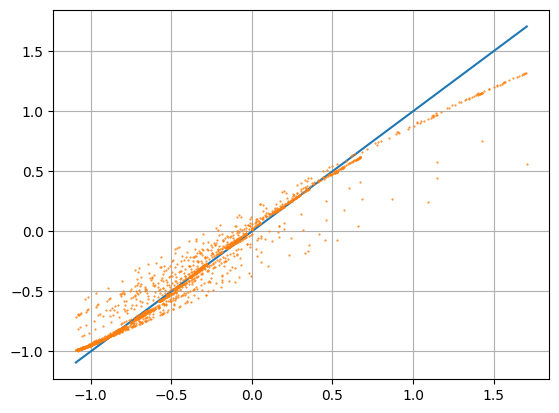

In [15]:
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)])
plt.plot(y_test, model(torch.tensor(x_test).reshape(-1, 4).to(device)).cpu().detach().numpy(), '.', markersize=1)
plt.grid()
plt.show()